In [1]:
#Importing packages
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#creating the model based on feature matrix and optimal beta coeficients
def betaAndYtildeGenerator(X_train,y_train):
    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
    ytilde = X_train @ beta
    return beta,ytilde


In [3]:
#Setting up the Feature matrix
def X_generator(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)  # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


In [4]:
# split in training and test data
def traningDataGenerator(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state= 11)
    return X_train, X_test, y_train, y_test

In [5]:
#Functions for R2 and MSE
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [6]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [7]:
#Function for generating noise
def noiseGeneration(z_input, scaling = 1):
    np.random.seed(5)
    nosyZ= z_input + np.random.randn(*z_input.shape) * scaling
    return nosyZ

In [8]:
#Fuction for making x and y of given size
def makeData(n_size=20):
    x = np.linspace(0,1,n_size)
    y = np.linspace(0,1,n_size)
    return x,y

In [9]:
#Scaling function for the feature matrix
def scale(X_train,X_test,y_train,y_test):
    scaler = StandardScaler()
    scaler_x = scaler.fit(X_train) # Scaling x-data
    X_train_scaled = scaler_x.transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    scaler_y = scaler.fit(y_train.reshape(-1,1))
    y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()
    return X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled

In [10]:
np.random.seed(870)
N = 20 #data size
x, y = makeData(N)
x_mesh, y_mesh = np.meshgrid(x,y)

x_flat = np.ravel(x_mesh) 
y_flat = np.ravel(y_mesh)
print(x_flat.shape)
z = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z,0.1)

#creating lists
R2_test = []
R2_train = []
R2_test_scaled = []
R2_train_scaled = []
MSE_test = []
MSE_train = []
MSE_test_scaled = []
MSE_train_scaled = []
numOfPoly_index = []
beta_index = []
beta_index_scaled = []
numOfPoly_max = 15
#for loop for number of polynomials
for i in range(0, numOfPoly_max +1 ):
    numOfPoly = i  
    print(numOfPoly)
    X = X_generator(x_flat,y_flat, numOfPoly)
    Xs = X_generator(x_flat,y_flat, numOfPoly)
    if i > 0:
        Xs = np.delete(Xs,0,1)
    X_train, X_test, y_train, y_test = traningDataGenerator(X,z)
    X_train_s, X_test_s, y_train_s, y_test_s = traningDataGenerator(Xs,z)
    X_offset = np.mean(X_train,axis=0)
    y_offset = np.mean(y_train,axis=0)
    
    #scaling the data
    X_train_scaled, X_test_scaled, y_train_scaled,y_test_scaled = scale(X_train_s, X_test_s ,y_train_s,y_test_s)
    X_offset_scaled = np.mean(X_train_scaled,axis=0)
    y_offset_scaled = np.mean(y_train_scaled,axis=0)
    # matrix inversion to find beta
    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
    intercept = np.mean(y_offset - X_offset @ beta)
    beta_scaled = np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train_scaled #scaled
    intercept_scaled = np.mean(y_offset_scaled - X_offset_scaled @ beta_scaled)
    
    # and then make the prediction
    
    ytilde = X_train @ beta 
    ytilde_scaled = X_train_scaled @ beta_scaled + y_offset_scaled #scaled
    ypredict = X_test @ beta 
    ypredict_scaled = X_test_scaled @ beta_scaled + y_offset_scaled #scaled
    
    R2_test.append(R2(y_test,ypredict))
    R2_test_scaled.append(R2(y_test_scaled,ypredict_scaled)) #scaled
    
    R2_train.append(R2(y_train,ytilde))
    R2_train_scaled.append(R2(y_train_scaled,ytilde_scaled)) #scaled
    
    MSE_train.append(MSE(y_train,ytilde))
    MSE_train_scaled.append(MSE(y_train_scaled,ytilde_scaled)) #scaled
    
    MSE_test.append(MSE(y_test,ypredict))
    MSE_test_scaled.append(MSE(y_test_scaled,ypredict_scaled)) #scaled
    
    numOfPoly_index.append(numOfPoly)
    beta_index.append(beta)
    beta_index_scaled.append(beta_scaled) #scaled
     
print("Training R2")
print(R2(y_train,ytilde))
print("Training MSE")
print(MSE(y_train,ytilde))
print("Test R2")
print(R2(y_test,ypredict))
print("Test MSE")
print(MSE(y_test,ypredict))

print("Training MSE_scaled")
print(MSE(y_train,ytilde_scaled))

print("Test MSE_scaled")
print(MSE(y_test_scaled,ypredict_scaled))
print(beta_index[0])
print(intercept_scaled)
print(intercept)
print(beta_index_scaled[0])
print(y_offset)

(400,)
0


LinAlgError: Singular matrix

<Figure size 720x432 with 0 Axes>

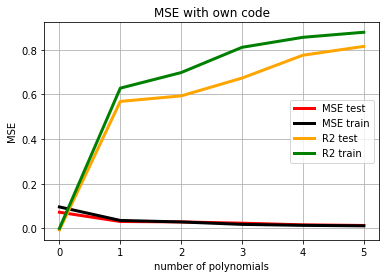

In [100]:
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.set_xlabel('number of polynomials')
ax.set_ylabel('MSE',color ="black")
ax.plot(numOfPoly_index,MSE_test ,  label='MSE test',linewidth=3.0, c= "red")
ax.plot(numOfPoly_index,MSE_train ,label="MSE train",linewidth=3.0, c= "black")
ax.plot(numOfPoly_index,R2_test ,  label='R2 test',linewidth=3.0, c= "orange")
ax.plot(numOfPoly_index,R2_train ,label="R2 train",linewidth=3.0, c= "green")
plt.title("MSE with own code")
plt.grid()

leg = ax.legend();

<Figure size 720x432 with 0 Axes>

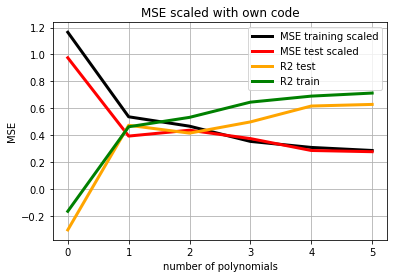

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.set_xlabel('number of polynomials')
ax.set_ylabel('MSE',color ="black")
ax.plot(numOfPoly_index,MSE_train_scaled ,  label='MSE training scaled',linewidth=3.0, c= "black")
ax.plot(numOfPoly_index,MSE_test_scaled ,label="MSE test scaled",linewidth=3.0, c= "red")
ax.plot(numOfPoly_index,R2_test_scaled ,  label='R2 test',linewidth=3.0, c= "orange")
ax.plot(numOfPoly_index,R2_train_scaled ,label="R2 train",linewidth=3.0, c= "green")
ax.set_title('MSE scaled with own code')
plt.grid()

leg = ax.legend();

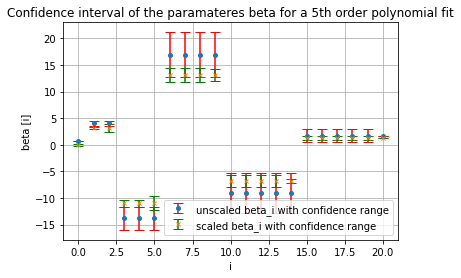

In [93]:
_PH_unscaled = len(beta) 
_PH_scaled = len(beta_scaled) 
variance_s = np.zeros(_PH_scaled +1)
CI_s = np.zeros(_PH_scaled +1)
variance = np.zeros(_PH_unscaled)
CI = np.zeros(_PH_unscaled )

for i in range(_PH_scaled ):
    variance[i] = 0.1**2 * np.linalg.pinv(X_train.T @ X_train)[i,i]
    CI[i] = 2*np.sqrt(variance[i])/np.sqrt(N)
    variance_s[i] = 0.1**2 * np.linalg.pinv(X_train_scaled.T @ X_train_scaled)[i,i]
    CI_s[i] = 2*np.sqrt(variance_s[i])/np.sqrt(N)

print("")
plt.errorbar(np.arange(0,_PH_unscaled), beta, yerr=CI, fmt='o', ecolor='red', capsize=5, markersize=4, label='unscaled beta_i with confidence range')
plt.errorbar(np.arange(0,_PH_scaled + 1),np.insert(beta_scaled,0,intercept_scaled), yerr=CI_s, fmt='x', ecolor='green', capsize=5, markersize=4, label='scaled beta_i with confidence range')
plt.xlabel('i')
plt.ylabel('beta [i]')
plt.grid()
plt.legend()
plt.title("Confidence interval of the paramateres beta for a 5th order polynomial fit")
plt.show()

In [116]:
np.random.seed(870)
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample



N = 20 #data size
x, y = makeData(N)
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh) 
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z,0.1)
max_degree = input("enter the max degree:")
max_degree = int(max_degree)
print("max degree is :",max_degree)

max_degree = np.arange(0,max_degree + 1)
MSE_test_sklearn = []
MSE_test_scaled_sklearn = []
numOfPoly_index = []
beta_foef = []
beta_foef_scaled = []
for degree in (max_degree):
    X = X_generator(x_flat,y_flat, degree)
    Xs = X_generator(x_flat,y_flat, degree)
    if degree > 0:
        Xs = np.delete(Xs,0,1)
    
  
   
    X_train, X_test, y_train, y_test = traningDataGenerator(X,z)
    X_train_s, X_test_s, y_train_s, y_test_s = traningDataGenerator(Xs,z)
    
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale(X_train_s, X_test_s ,y_train_s, y_test_s)
    
    poly_reg_model = linear_model.LinearRegression(fit_intercept = False)
    poly_reg_model_s = linear_model.LinearRegression(fit_intercept = True) # Can have fit intercept = True for scaled model 
    poly_reg_model.fit(X_train, y_train)
    poly_reg_model_s.fit(X_train_scaled, y_train_scaled)
    
    y_tilde_scaled = poly_reg_model_s.predict(X_train_scaled)
    y_pred_scaled = poly_reg_model_s.predict(X_test_scaled)
    
    y_tilde = poly_reg_model.predict(X_train)
    y_pred = poly_reg_model.predict(X_test)
    
    #MSE_train_scaled.append(mean_squared_error(y_train_scaled, y_tilde_scaled))
    MSE_test_scaled_sklearn.append(MSE(y_test_scaled, y_pred_scaled))
    #MSE_train_sklearn.append(mean_squared_error(y_train_scaled, y_tilde_scaled))
    MSE_test_sklearn.append(mean_squared_error(y_test, y_pred))
    numOfPoly_index.append(degree)
    beta_foef.append(poly_reg_model.coef_)
    beta_foef_scaled.append(poly_reg_model_s.coef_)
    print(degree)


# The coefficients
print("Coefficients: \n", poly_reg_model.coef_)
print("Intercept scaled: \n", poly_reg_model_s.intercept_)
print("Intercept: \n", poly_reg_model.intercept_)


print(" MSE training : \n",mean_squared_error(y_tilde, y_train))
print(" MSE test : \n",mean_squared_error(y_test, y_pred))

print(" MSE training_scaled : \n",mean_squared_error(y_tilde_scaled,y_train_scaled))
print(" MSE test_scaled : \n",mean_squared_error(y_test_scaled, y_pred_scaled))



enter the max degree:15
max degree is : 15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Coefficients: 
 [ 8.09466934e-01 -7.76160236e+01 -1.38978416e+02  3.42989044e+03
  2.59155159e+03  3.28832978e+03 -5.91450574e+04 -3.46542450e+04
 -4.86249995e+04 -2.78494489e+04  5.51749994e+05  3.74917676e+05
  4.11398470e+05  3.66967966e+05  6.98711351e+04 -3.16476728e+06
 -3.04644611e+06 -1.79592338e+06 -3.53406268e+06 -9.23909317e+05
  6.22019870e+05  1.18734463e+07  1.70785690e+07  6.23266881e+06
  1.28977594e+07  1.60312273e+07 -2.72053098e+06 -7.44115248e+06
 -2.98736003e+07 -6.61436288e+07 -2.18313677e+07 -2.38949827e+07
 -6.32956904e+07 -3.55340219e+07  2.48362022e+07  4.10972606e+07
  4.98349692e+07  1.81507337e+08  6.44279891e+07  3.42396366e+07
  1.01067685e+08  1.89451266e+08  9.92296174e+06 -7.16921617e+07
 -1.47134856e+08 -5.06258756e+07 -3.60391680e+08 -1.35150773e+08
 -6.28025968e+07 -8.17724794e+07 -2.94801936e+08 -3.46205526e+08
  1.53252783e+08  9.66274132e+07  3.66341568e+08  1.905283

<Figure size 720x432 with 0 Axes>

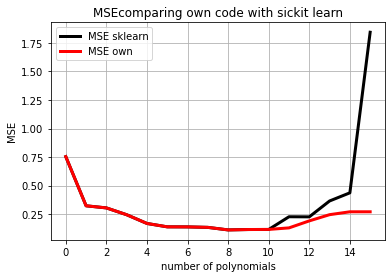

In [117]:
0.1806787700906097
5.671487281234656e-14
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.set_xlabel('number of polynomials')
ax.set_ylabel('MSE',color ="black")
#ax.plot(np.insert(MSE_test_scaled,0,0.7,axis = 0) ,  label='MSE own code',linewidth=3.0, c= "red")
ax.plot(MSE_test_scaled_sklearn ,label="MSE sklearn",linewidth=3.0, c= "black")
ax.plot(MSE_test_scaled ,label="MSE own",linewidth=3.0, c= "red")
#ax.plot(MSE_test_sklearn ,label="MSE sklearn unskaled",linewidth=3.0, c= "green")
#ax.plot(MSE_test ,label="MSE own unskaled",linewidth=3.0, c= "yellow")
plt.title("MSEcomparing own code with sickit learn")
plt.grid()

leg = ax.legend();


In [ ]:
(beta_foef_scaled)

In [ ]:
(beta_foef)

In [ ]:
print(X_test_scaled.shape)
print(X_test.shape)